In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'

In [5]:
era5_max_quantiles = xr.open_dataset('%s/era5_tw_max_quantiles.nc'%dirHeatData)
lat = era5_max_quantiles.latitude.values
lon = era5_max_quantiles.longitude.values

In [6]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)
    
with open('%s/kdd-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    kdd_trends = pickle.load(f)
with open('%s/gdd-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    gdd_trends = pickle.load(f)
with open('%s/pr-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    pr_trends = pickle.load(f)

In [7]:
# for y, year in enumerate(range(1981, 2019+1)):
#     os.rename('heat_wave_days/era5_cold_wave_days_%d.dat'%year, 'heat_wave_days/era5_t_min_wave_days_%d.dat'%year)

In [240]:
yearRange = [1981, 1987]

wave_days_tw_max = np.full([lat.size, lon.size, len(range(yearRange[0], yearRange[1])), 3], np.nan)
wave_days_inds_tw_max = {}
wave_days_values_tw_max = {}

wave_days_tx_max = np.full([lat.size, lon.size, len(range(yearRange[0], yearRange[1])), 3], np.nan)
wave_days_inds_tx_max = {}
wave_days_values_tx_max = {}

for y, year in enumerate(range(yearRange[0], yearRange[1])):
    print(year)

    with open('%s/heat-wave-days/full-year/era5_mx2t_heat_wave_days_full_year_%d.dat'%(dirHeatData, year), 'rb') as f:
        cur_tx_heatwave_days = pickle.load(f)
        wave_days_tx_max[:, :, y, :] = cur_tx_heatwave_days[:, :, :]
    with open('%s/heat-wave-days/full-year/era5_mx2t_heat_wave_days_ind_full_year_%d.dat'%(dirHeatData, year), 'rb') as f:
        wave_days_inds_tx_max[year] = pickle.load(f)
    with open('%s/heat-wave-days/full-year/era5_mx2t_heat_wave_days_all_values_full_year_%d.dat'%(dirHeatData, year), 'rb') as f:
        cur_tx_heatwave_days_values = pickle.load(f)
        wave_days_values_tx_max[year] = np.array(cur_tx_heatwave_days_values, dtype=object)
    
    with open('%s/heat-wave-days/full-year/era5_tw_heat_wave_days_full_year_%d.dat'%(dirHeatData, year), 'rb') as f:
        cur_tw_heatwave_days = pickle.load(f)
        wave_days_tw_max[:, :, y, :] = cur_tw_heatwave_days[:, :, :]
    with open('%s/heat-wave-days/full-year/era5_tw_heat_wave_days_ind_full_year_%d.dat'%(dirHeatData, year), 'rb') as f:
        wave_days_inds_tw_max[year] = pickle.load(f)
    with open('%s/heat-wave-days/full-year/era5_tw_heat_wave_days_all_values_full_year_%d.dat'%(dirHeatData, year), 'rb') as f:
        cur_tw_heatwave_days_values = pickle.load(f)
        wave_days_values_tw_max[year] = np.array(cur_tw_heatwave_days_values, dtype=object)

1981
1982
1983
1984
1985
1986


In [34]:
# wave_days_t_max_xr = xr.DataArray(data=wave_days_t_max,
#                                 dims=['lat', 'lon', 'time', 'q'], 
#                                 coords={'lat':era5_lat, 'lon':era5_lon, 'time':range(yearRange[0], yearRange[1]+1), 'q':[0,1,2,3,4,5]})
# wave_days_t_max_xr = xr.Dataset({'t_max':wave_days_t_max_xr})


wave_days_tw_max_xr = xr.DataArray(data=wave_days_tw_max,
                                dims=['lat', 'lon', 'time', 'q'], 
                                coords={'lat':lat, 'lon':lon, 'time':range(yearRange[0], yearRange[1]), 'q':[0,1,2]})
wave_days_tw_max_xr = xr.Dataset({'tw_max':wave_days_tw_max_xr})


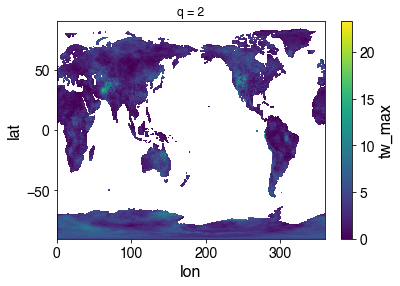

In [12]:
wave_days_tw_max_xr.tw_max.mean(dim='time').sel(q=2).plot()

In [241]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptList = []
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i in range(len(data)):
        # start sequence
        if ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif ((data[i]-data[i-1]) > 1 and ptCur[0] >= 0):
            ptCur = (ptCur[0], i-1)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptList.append(ptCur)
            ptCur = (i, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptList.append(ptCur)
    return ptList

In [413]:
waveInds_tw = []
waveVals_tw = []
waveVals_tx_during_tw = []

waveInds_tx = []
waveVals_tx = []
waveVals_tw_during_tx = []

wave_min_len = 5
wave_max_len = 5

lat_inds = np.where((lat < 55) & (lat >= 30))[0]
# lat_inds = np.where((lat < 15) & (lat >= -15))[0]
# lon_inds = np.arange(lon.size)#
# lon_inds = np.where((lon < 300) & (lon >= 220))[0]
lon_inds = np.where((lon < 60) & (lon >= 0))[0]

q = 2
for year in range(yearRange[0], yearRange[1]):
    for xlat in lat_inds:
        for ylon in lon_inds:
            curInds_tw = wave_days_inds_tw_max[year][xlat, ylon, q]
            if len(curInds_tw) > 0:
                waves_tw = findConsec(curInds_tw[0])
                for wave in waves_tw:
                    if wave[1]-wave[0]+1 >= wave_min_len and wave[1]-wave[0]+1 <= wave_max_len:
                        waveVals_tw.append(wave_days_values_tw_max[year][xlat, ylon, q][0][curInds_tw[0][wave[0]:wave[1]+1]])
                        waveVals_tx_during_tw.append(wave_days_values_tx_max[year][xlat, ylon, q][0][curInds_tw[0][wave[0]:wave[1]+1]])
            
            curInds_tx = wave_days_inds_tx_max[year][xlat, ylon, q]
            if len(curInds_tx) > 0:
                waves_tx = findConsec(curInds_tx[0])
                for wave in waves_tx:
                    if wave[1]-wave[0]+1 >= wave_min_len and wave[1]-wave[0]+1 <= wave_max_len:
                        waveVals_tx.append(wave_days_values_tx_max[year][xlat, ylon, q][0][curInds_tx[0][wave[0]:wave[1]+1]])
                        waveVals_tw_during_tx.append(wave_days_values_tw_max[year][xlat, ylon, q][0][curInds_tx[0][wave[0]:wave[1]+1]])
                        
waveVals_tw = np.array(waveVals_tw)
waveVals_tx_during_tw = np.array(waveVals_tx_during_tw)
waveVals_tx = np.array(waveVals_tx)
waveVals_tw_during_tx = np.array(waveVals_tw_during_tx)

In [414]:
dayoffset_tw = np.full([waveVals_tw.shape[0], wave_max_len], np.nan)
dayoffset_tx_during_tw = np.full([waveVals_tw.shape[0], wave_max_len], np.nan)
dayoffset_tx = np.full([waveVals_tx.shape[0], wave_max_len], np.nan)
dayoffset_tw_during_tx = np.full([waveVals_tx.shape[0], wave_max_len], np.nan)

lens_tw = []
for w in range(waveVals_tw.shape[0]):
    waveVals_tw[w] = np.array([x-waveVals_tw[w][0] for x in waveVals_tw[w]])
    waveVals_tx_during_tw[w] = np.array([x-waveVals_tx_during_tw[w][0] for x in waveVals_tx_during_tw[w]])
    lens_tw.append(len(waveVals_tw[w]))
    for i in range(dayoffset_tw.shape[1]):
        if len(waveVals_tw[w]) > i:
            dayoffset_tw[w, i] = waveVals_tw[w][i]
            dayoffset_tx_during_tw[w, i] = waveVals_tx_during_tw[w][i]
dayoffset_tw[abs(dayoffset_tw)>10]=np.nan


lens_tx = []
for w in range(waveVals_tx.shape[0]):
    waveVals_tx[w] = np.array([x-waveVals_tx[w][0] for x in waveVals_tx[w]])
    waveVals_tw_during_tx[w] = np.array([x-waveVals_tw_during_tx[w][0] for x in waveVals_tw_during_tx[w]])
    lens_tx.append(len(waveVals_tx[w]))
    for i in range(dayoffset_tx.shape[1]):
        if len(waveVals_tx[w]) > i:
            dayoffset_tx[w, i] = waveVals_tx[w][i]
            dayoffset_tw_during_tx[w, i] = waveVals_tw_during_tx[w][i]
dayoffset_tx[abs(dayoffset_tx)>10]=np.nan

In [415]:
ind_tx_during_tw_neg = np.where(np.nanmean(dayoffset_tx_during_tw[:,1:], axis=1)<0)[0]
ind_tx_during_tw_pos = np.where(np.nanmean(dayoffset_tx_during_tw[:,1:], axis=1)>0)[0]

ind_tw_during_tx_neg = np.where(np.nanmean(dayoffset_tw_during_tx[:,1:], axis=1)<0)[0]
ind_tw_during_tx_pos = np.where(np.nanmean(dayoffset_tw_during_tx[:,1:], axis=1)>0)[0]

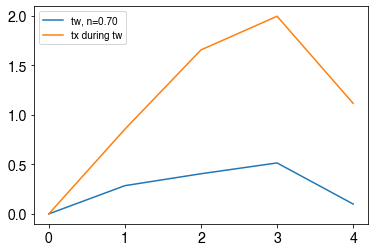

In [416]:
plt.plot(np.nanmedian(dayoffset_tw[ind_tx_during_tw_pos,:], axis=0), label='tw, n=%.2f'%(ind_tx_during_tw_pos.size/dayoffset_tw.shape[0]))
plt.plot(np.nanmedian(dayoffset_tx_during_tw[ind_tx_during_tw_pos,:], axis=0), label='tx during tw')
plt.legend()

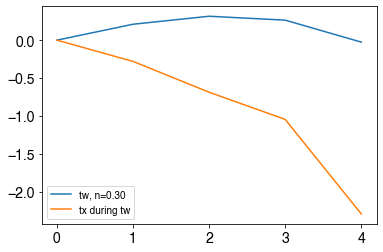

In [417]:
plt.plot(np.nanmedian(dayoffset_tw[ind_tx_during_tw_neg,:], axis=0), label='tw, n=%.2f'%(ind_tx_during_tw_neg.size/dayoffset_tw.shape[0]))
plt.plot(np.nanmedian(dayoffset_tx_during_tw[ind_tx_during_tw_neg,:], axis=0), label='tx during tw')
plt.legend()

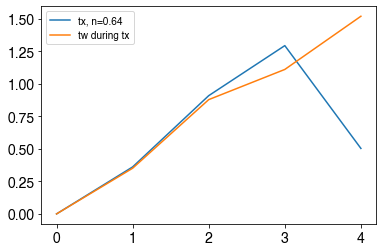

In [418]:
plt.plot(np.nanmedian(dayoffset_tx[ind_tw_during_tx_pos,:], axis=0), label='tx, n=%.2f'%(ind_tw_during_tx_pos.size/dayoffset_tx.shape[0]))
plt.plot(np.nanmedian(dayoffset_tw_during_tx[ind_tw_during_tx_pos,:], axis=0), label='tw during tx')
plt.legend()

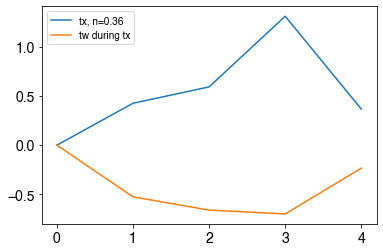

In [419]:
plt.plot(np.nanmedian(dayoffset_tx[ind_tw_during_tx_neg,:], axis=0), label='tx, n=%.2f'%(ind_tw_during_tx_neg.size/dayoffset_tx.shape[0]))
plt.plot(np.nanmedian(dayoffset_tw_during_tx[ind_tw_during_tx_neg,:], axis=0), label='tw during tx')
plt.legend()

In [91]:
np.nanmean(lens_tw)

6.444444444444445

In [39]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData):
    wave_days_t_max_trends = xr.apply_ufunc(new_linregress, wave_days_t_max_xr.time, wave_days_t_max_xr.t_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'wb') as f:
        pickle.dump(wave_days_t_max_trends, f)
else:
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'rb') as f:
        wave_days_t_max_trends = pickle.load(f)

NameError: name 'wave_days_t_max_xr' is not defined

In [25]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData):
    wave_days_tw_max_trends = xr.apply_ufunc(new_linregress, wave_days_tw_max_xr.time, wave_days_tw_max_xr.tw_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData, 'wb') as f:
        pickle.dump(wave_days_tw_max_trends, f)
else:
    with open('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData, 'rb') as f:
        wave_days_tw_max_trends = pickle.load(f)

CPU times: user 9min 14s, sys: 6.41 s, total: 9min 20s
Wall time: 9min 58s


In [37]:
wave_days_t_max_trends *= 10
# wave_days_t_min_trends *= 10
wave_days_tw_max_trends *= 10
# wave_days_tw_min_trends *= 10

In [39]:
%%time

sig_trends_only = False
sig_level = 0.1

kdd_trends_zonal_anom = kdd_trends - np.matlib.repmat(np.nanmean(kdd_trends, axis=1), 1, 1).T
gdd_trends_zonal_anom = gdd_trends - np.matlib.repmat(np.nanmean(gdd_trends, axis=1), 1, 1).T

trends_wave_days_t_max_zonal_anom = np.full([wave_days_t_max_trends.shape[0], wave_days_t_max_trends.shape[1], wave_days_t_max_trends.shape[2]], np.nan)
trends_wave_days_tw_max_zonal_anom = np.full([wave_days_tw_max_trends.shape[0], wave_days_tw_max_trends.shape[1], wave_days_tw_max_trends.shape[2]], np.nan)

# trends_wave_days_t_min_zonal_anom = np.full([wave_days_t_min_trends.shape[0], wave_days_t_min_trends.shape[1], wave_days_t_min_trends.shape[2]], np.nan)
# trends_wave_days_tw_min_zonal_anom = np.full([wave_days_tw_min_trends.shape[0], wave_days_tw_min_trends.shape[1], wave_days_tw_min_trends.shape[2]], np.nan)

for q in range(wave_days_t_max_trends.shape[2]):
    trends_wave_days_t_max_zonal_anom[:,:,q] = wave_days_t_max_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_t_max_trends[:,:,q,0], axis=1), 1, 1).T
    trends_wave_days_tw_max_zonal_anom[:,:,q] = wave_days_tw_max_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_tw_max_trends[:,:,q,0], axis=1), 1, 1).T
    
#     trends_wave_days_t_min_zonal_anom[:,:,q] = wave_days_t_min_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_t_min_trends[:,:,q,0], axis=1), 1, 1).T
#     trends_wave_days_tw_min_zonal_anom[:,:,q] = wave_days_tw_min_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_tw_min_trends[:,:,q,0], axis=1), 1, 1).T
    
    if sig_trends_only:
        trends_wave_days_t_max_zonal_anom[wave_days_t_max_trends[:,:,q,3] > sig_level, q] = np.nan
        trends_wave_days_tw_max_zonal_anom[wave_days_tw_max_trends[:,:,q,3] > sig_level, q] = np.nan
        
#         trends_wave_days_t_min_zonal_anom[wave_days_t_min_trends[:,:,q,3] > sig_level, q] = np.nan
#         trends_wave_days_tw_min_zonal_anom[wave_days_tw_min_trends[:,:,q,3] > sig_level, q] = np.nan
    

CPU times: user 1.01 s, sys: 20.1 ms, total: 1.03 s
Wall time: 1.03 s


In [40]:
usLat = [150,300]
usLon = [940,1150]
euroLat = [100,200]
euroLon = [0,200]

chinaLat = [150,300]
chinaLon = [350,500]

allLat = [0,-1]
allLon = [0,-1]

selLat = allLat
selLon = allLon

trends_wave_days_t_max_zonal_anom = trends_wave_days_t_max_zonal_anom[selLat[0]:selLat[1],selLon[0]:selLon[1],:]
trends_wave_days_tw_max_zonal_anom = trends_wave_days_tw_max_zonal_anom[selLat[0]:selLat[1],selLon[0]:selLon[1],:]
crop_ha_regrid = crop_ha_regrid[selLat[0]:selLat[1],selLon[0]:selLon[1]]

NameError: name 'crop_ha_regrid' is not defined

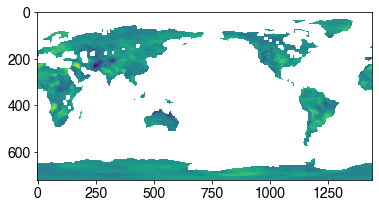

In [41]:
plt.imshow(trends_wave_days_tw_max_zonal_anom[:,:,5])

In [98]:
crop_ha_regrid_1d = np.reshape(crop_ha_regrid, [crop_ha_regrid.size, 1])
irrigation_regrid_1d = np.reshape(irrigation_data_regrid, [irrigation_data_regrid.size, 1])

kdd_trends_1d = np.reshape(kdd_trends, [kdd_trends.size, 1])
kdd_trends_zonal_anom_1d = np.reshape(kdd_trends_zonal_anom, [kdd_trends_zonal_anom.size, 1])

gdd_trends_1d = np.reshape(gdd_trends, [gdd_trends.size, 1])
gdd_trends_zonal_anom_1d = np.reshape(gdd_trends_zonal_anom, [gdd_trends_zonal_anom.size, 1])

trends_wave_days_t_max_1d = np.full([wave_days_t_max_trends[:,:,0,0].values.size, wave_days_t_max_trends.values.shape[2]], np.nan)
trends_wave_days_t_max_zonal_anom_1d = np.full([trends_wave_days_t_max_zonal_anom[:,:,0].size, trends_wave_days_t_max_zonal_anom.shape[2]], np.nan)

trends_wave_days_tw_max_1d = np.full([wave_days_tw_max_trends[:,:,0,0].values.size, wave_days_tw_max_trends.values.shape[2]], np.nan)
trends_wave_days_tw_max_zonal_anom_1d = np.full([trends_wave_days_tw_max_zonal_anom[:,:,0].size, trends_wave_days_tw_max_zonal_anom.shape[2]], np.nan)

trends_wave_days_t_min_1d = np.full([wave_days_t_min_trends[:,:,0,0].values.size, wave_days_t_min_trends.values.shape[2]], np.nan)
trends_wave_days_t_min_zonal_anom_1d = np.full([trends_wave_days_t_min_zonal_anom[:,:,0].size, trends_wave_days_t_min_zonal_anom.shape[2]], np.nan)

trends_wave_days_tw_min_1d = np.full([wave_days_tw_min_trends[:,:,0,0].values.size, wave_days_tw_min_trends.values.shape[2]], np.nan)
trends_wave_days_tw_min_zonal_anom_1d = np.full([trends_wave_days_tw_min_zonal_anom[:,:,0].size, trends_wave_days_tw_min_zonal_anom.shape[2]], np.nan)

for q in range(wave_days_t_max_trends.shape[2]):
    trends_wave_days_t_max_1d[:,q] = np.reshape(wave_days_t_max_trends[:,:,q,0].values, [wave_days_t_max_trends[:,:,q,0].values.size])
    trends_wave_days_t_max_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_t_max_zonal_anom[:,:,q], [trends_wave_days_t_max_zonal_anom[:,:,q].size])
    
    trends_wave_days_tw_max_1d[:,q] = np.reshape(wave_days_tw_max_trends[:,:,q,0].values, [wave_days_tw_max_trends[:,:,q,0].values.size])
    trends_wave_days_tw_max_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_tw_max_zonal_anom[:,:,q], [trends_wave_days_tw_max_zonal_anom[:,:,q].size])
    
    trends_wave_days_t_min_1d[:,q] = np.reshape(wave_days_t_min_trends[:,:,q,0].values, [wave_days_t_min_trends[:,:,q,0].values.size])
    trends_wave_days_t_min_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_t_min_zonal_anom[:,:,q], [trends_wave_days_t_min_zonal_anom[:,:,q].size])
    
    trends_wave_days_tw_min_1d[:,q] = np.reshape(wave_days_tw_min_trends[:,:,q,0].values, [wave_days_tw_min_trends[:,:,q,0].values.size])
    trends_wave_days_tw_min_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_tw_min_zonal_anom[:,:,q], [trends_wave_days_tw_min_zonal_anom[:,:,q].size])

In [99]:
q = 5

crop_ha_regrid_1d[crop_ha_regrid_1d==0] = np.nan
# crop_ha_regrid_1d[crop_ha_regrid_1d<1] = np.nan

# nn = np.where((~np.isnan(kdd_trends_zonal_anom_1d)) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_kdd = sm.OLS(kdd_trends_zonal_anom_1d[nn], X).fit()

# nn = np.where((~np.isnan(gdd_trends_zonal_anom_1d)) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_gdd = sm.OLS(gdd_trends_zonal_anom_1d[nn], X).fit()

nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[:,q], [trends_wave_days_t_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
X = sm.add_constant(crop_ha_regrid_1d[nn])
mdl_wave_days_t_max = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_min_zonal_anom_1d[:,q], [trends_wave_days_t_min_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_wave_days_t_min = sm.OLS(trends_wave_days_t_min_zonal_anom_1d[:,q][nn], X).fit()

nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[:,q], [trends_wave_days_tw_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
X = sm.add_constant(crop_ha_regrid_1d[nn])
mdl_wave_days_tw_max = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_min_zonal_anom_1d[:,q], [trends_wave_days_tw_min_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_wave_days_tw_min = sm.OLS(trends_wave_days_tw_min_zonal_anom_1d[:,q][nn], X).fit()

# IRRIGATION DATA
# nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[:,q], [trends_wave_days_t_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(irrigation_regrid_1d)))[0]
# X = sm.add_constant(irrigation_regrid_1d[nn])
# mdl_wave_days_t_max_irr = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[:,q], [trends_wave_days_tw_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(irrigation_regrid_1d)))[0]
# X = sm.add_constant(irrigation_regrid_1d[nn])
# mdl_wave_days_tw_max_irr = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][nn], X).fit()

In [201]:
# plt.scatter(irrigation_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:,q])
# plt.plot([x1, x2], [mdl_wave_days_t_max_irr.params[0], mdl_wave_days_t_max_irr.params[0]+x2*mdl_wave_days_t_max_irr.params[1]], '--k', lw=2)

In [73]:
slopes_t = []
slopes_tw = []
n = 10
for pct in range(0, 101, n):
    crop_ha_regrid_1d_sel = np.where((crop_ha_regrid_1d>pct) & (crop_ha_regrid_1d<pct+n))[0]
    nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[crop_ha_regrid_1d_sel,q], [len(crop_ha_regrid_1d_sel), 1]))) & (~np.isnan(crop_ha_regrid_1d[crop_ha_regrid_1d_sel])))[0]
    if len(nn) > 50:
        X = sm.add_constant(crop_ha_regrid_1d[crop_ha_regrid_1d_sel[nn]])
        mdl_wave_days_t_max_partial = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][crop_ha_regrid_1d_sel[nn]], X).fit()
        slopes_t.append(mdl_wave_days_t_max_partial.params[1])
    
    nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[crop_ha_regrid_1d_sel,q], [len(crop_ha_regrid_1d_sel), 1]))) & (~np.isnan(crop_ha_regrid_1d[crop_ha_regrid_1d_sel])))[0]
    if len(nn) > 50:
        X = sm.add_constant(crop_ha_regrid_1d[crop_ha_regrid_1d_sel[nn]])
        mdl_wave_days_tw_max_partial = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][crop_ha_regrid_1d_sel[nn]], X).fit()
        slopes_tw.append(mdl_wave_days_tw_max_partial.params[1])

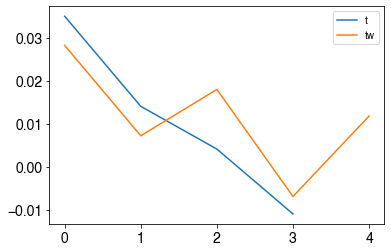

In [74]:
plt.plot(slopes_t, label='t')
plt.plot(slopes_tw, label='tw')
plt.legend()

In [168]:
mdl_wave_days_t_max.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     105.2
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           3.03e-24
Time:                        17:33:24   Log-Likelihood:                -2131.3
No. Observations:                2782   AIC:                             4267.
Df Residuals:                    2780   BIC:                             4278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9775      0.014     68.788      0.000       0.950       1.005
x1            -0.0151      0.001    -10.255      0.000      -0.018      -0.012
==============================================================================
Omnibus:                      125.622   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.468
Skew:                          -0.537   Prob(JB):                     5.19e-31
Kurtosis:                       2.778   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

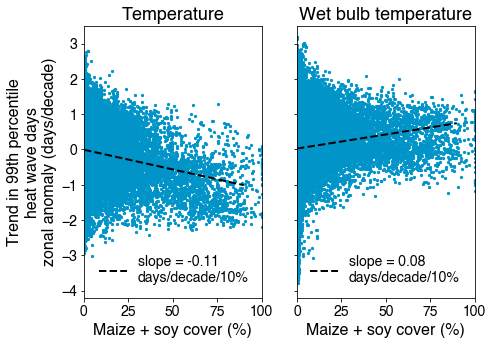

In [100]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,5))

x1 = 0
x2 = 90

ax1.scatter(crop_ha_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax1.plot([x1, x2], [mdl_wave_days_t_max.params[0], mdl_wave_days_t_max.params[0]+x2*mdl_wave_days_t_max.params[1]], '--k', lw=2, \
         label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_t_max.params[1]*10))
ax1.set_title('Temperature', fontsize=18)
ax1.set_xlabel('Maize + soy cover (%)')
ax1.set_ylabel('Trend in 99th percentile\nheat wave days\nzonal anomaly (days/decade)')
ax1.set_xlim([0, 100])
ax1.set_ylim([-4.2, 3.5])
ax1.legend(prop={'size': 14}, frameon=False)

ax2.scatter(crop_ha_regrid_1d, trends_wave_days_tw_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax2.plot([x1, x2], [mdl_wave_days_tw_max.params[0], mdl_wave_days_tw_max.params[0]+x2*mdl_wave_days_tw_max.params[1]], '--k', lw=2, \
        label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_tw_max.params[1]*10))
ax2.set_title('Wet bulb temperature', fontsize=18)
ax2.set_xlabel('Maize + soy cover (%)')
ax2.set_yticks(np.arange(-4, 3.1))
ax2.set_xlim([0, 100])
ax2.set_ylim([-4.2, 3.5])
ax2.legend(prop={'size': 14}, frameon=False)

# plt.savefig('figs/cropland-t-tw-zonal-mean-trends.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

# ax3.scatter(crop_ha_regrid_1d, trends_wave_days_t_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax3.plot([x1, x2], [mdl_wave_days_t_min.params[0], mdl_wave_days_t_min.params[0]+x2*mdl_wave_days_t_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_t_min.params[1]*10))
# ax3.set_title('T_min, q = %d'%q)
# ax3.set_xlabel('Crop cover (%)')
# ax3.set_ylabel('Cold wave days trend\nzonal anomaly\n(days/decade)')
# ax3.set_xlim([0, 100])
# # ax3.set_ylim([-4, 4])
# ax3.legend()

# ax4.scatter(crop_ha_regrid_1d, trends_wave_days_tw_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax4.plot([x1, x2], [mdl_wave_days_tw_min.params[0], mdl_wave_days_tw_min.params[0]+x2*mdl_wave_days_tw_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_tw_min.params[1]*10))
# ax4.set_title('TW_min, q = %d'%q)
# ax4.set_xlabel('Crop cover (%)')
# ax4.set_xlim([0, 100])
# # ax4.set_ylim([-4, 4])
# ax4.legend()


In [72]:
ind_no_crop = np.where((crop_ha_regrid_1d<=1))[0]
ind_low_crop = np.where((crop_ha_regrid_1d>1) & (crop_ha_regrid_1d<=25))[0]
ind_high_crop = np.where((crop_ha_regrid_1d>25))[0]

t_max_trend_no_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_no_crop, q])
t_max_trend_low_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_low_crop, q])
t_max_trend_high_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_high_crop, q])

tw_max_trend_no_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_no_crop, q])
tw_max_trend_low_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_low_crop, q])
tw_max_trend_high_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_high_crop, q])


print(t_max_trend_no_crop, t_max_trend_low_crop, t_max_trend_high_crop)
print(tw_max_trend_no_crop, tw_max_trend_low_crop, tw_max_trend_high_crop)

0.8347558764880052 0.9666224785926698 0.7906920555326428
0.7798830927907219 0.9551428739071759 1.1489443741759706
